# Imports

In [133]:
import os
import numpy as np
import tensorflow as tf
import sys
import pickle
from tqdm import tqdm
#%load_ext autoreload

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

TARGET_SR = 16000            # YAMNet requires 16kHz       

#%autoreload 2
from src.models.single_stage_yamnet_frame import *
from src.config import DETECTION_TRAIN_PATH, DETECTION_TEST_PATH, CLASSES
from src.utils.audio_to_spectrograms import display_spectrogram

import sed_eval

In [134]:
data_events = pickle.load(open('data/processed/yamnet/spectrograms_train_list.pkl', 'rb'))
data = pickle.load(open('data/processed/yamnet/spectrograms_train.pkl', 'rb'))
print(data.keys())
NUM_CLASSES = len(CLASSES)
class_to_id = {c:(i+1) for i,c in enumerate(CLASSES)} # id to start from 1, 0 is reserved for no event
print("Classes:", CLASSES)

dict_keys(['sr', 'S_db', 'files', 'onset', 'offset', 'event_label', 'background_label'])
Classes: ['cough', 'dog_bark', 'gun_shot', 'siren', 'car_horn']


In [135]:
# manual train test split (stratified)
np.random.seed(0)
train_size = 0.8
train_idx = []
for label in np.unique(data['event_label']):
    choices = np.where(data['event_label'] == label)[0]
    train_idx.append(np.sort(np.random.choice(choices, size = int(np.round(len(choices)*train_size)), replace = False)))
train_idx = np.sort(np.concatenate(train_idx))
val_idx = [i for i in range(len(data['event_label'])) if i not in train_idx]
len(train_idx)

2001

In [136]:
filepaths = [os.path.join(DETECTION_TRAIN_PATH, file) for file in data['files']]
labels = [class_to_id[c] for c in data['event_label']]

train_files = [filepaths[i] for i in train_idx]
train_labels = [(data['onset'][i], data['offset'][i], labels[i]) for i in train_idx]
val_files = [filepaths[i] for i in val_idx]
val_labels = [(data['onset'][i], data['offset'][i], labels[i]) for i in val_idx]
val_onsets = [data['onset'][i] for i in val_idx]
val_offsets = [data['offset'][i] for i in val_idx]

In [145]:
trainer = Trainer(train_files, train_labels, val_files, val_labels, lr = 1e-4, epochs = 50, batch_size = 16, model_save_dir = "../src/models/yamnet_framewise.keras", classes = CLASSES)

In [146]:
# uncomment to train model again
trainer.train()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ yam_net_layer (YamNetLayer)     │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 256)      │       262,400 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 6)        │         1,542 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,942 (1.01 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
    126/Unknown 460s 4s/step - accuracy: 0.7464 - loss: 1.0516

2025-12-01 03:00:18.662229: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/mnt/c/Users/tannl/OneDrive - Georgia Institute of Technology/OMSA/CS7643 Deep Learning/dl_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.8188 - loss: 0.7571 - val_accuracy: 0.8699 - val_loss: 0.4571 - learning_rate: 1.0000e-04
Epoch 2/50


2025-12-01 03:02:05.442434: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.8899 - loss: 0.4063 - val_accuracy: 0.8940 - val_loss: 0.3746 - learning_rate: 1.0000e-04
Epoch 3/50


2025-12-01 03:11:17.507157: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.9036 - loss: 0.3591 - val_accuracy: 0.9033 - val_loss: 0.3477 - learning_rate: 1.0000e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 569s 5s/step - accuracy: 0.9098 - loss: 0.3369 - val_accuracy: 0.9102 - val_loss: 0.3310 - learning_rate: 1.0000e-04
Epoch 5/50


2025-12-01 03:29:58.186843: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 633s 5s/step - accuracy: 0.9147 - loss: 0.3227 - val_accuracy: 0.9142 - val_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 568s 5s/step - accuracy: 0.9177 - loss: 0.3116 - val_accuracy: 0.9164 - val_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.9202 - loss: 0.3046 - val_accuracy: 0.9188 - val_loss: 0.3046 - learning_rate: 1.0000e-04
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.9217 - loss: 0.2975 - val_accuracy: 0.9212 - val_loss: 0.2990 - learning_rate: 1.0000e-04
Epoch 9/50


2025-12-01 04:07:29.723464: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.9235 - loss: 0.2922 - val_accuracy: 0.9223 - val_loss: 0.2949 - learning_rate: 1.0000e-04
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 470s 4s/step - accuracy: 0.9251 - loss: 0.2862 - val_accuracy: 0.9229 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.9260 - loss: 0.2819 - val_accuracy: 0.9253 - val_loss: 0.2873 - learning_rate: 1.0000e-04
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 545s 4s/step - accuracy: 0.9275 - loss: 0.2787 - val_accuracy: 0.9248 - val_loss: 0.2844 - learning_rate: 1.0000e-04
Epoch 13/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.9287 - loss: 0.2744 - val_accuracy: 0.9263 - val_loss: 0.2816 - learning_rate: 1.0000e-04
Epoch 14/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - accuracy: 0.9286 - loss: 0.2723 - val_accuracy: 0.9264 - val_loss: 0.2803 - learning_rate: 1.0000e-04
Epoch 15/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - accuracy

2025-12-01 05:17:12.408654: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.9311 - loss: 0.2634 - val_accuracy: 0.9283 - val_loss: 0.2730 - learning_rate: 1.0000e-04
Epoch 18/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.9320 - loss: 0.2610 - val_accuracy: 0.9292 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 19/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.9327 - loss: 0.2587 - val_accuracy: 0.9300 - val_loss: 0.2694 - learning_rate: 1.0000e-04
Epoch 20/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 563s 4s/step - accuracy: 0.9329 - loss: 0.2574 - val_accuracy: 0.9291 - val_loss: 0.2689 - learning_rate: 1.0000e-04
Epoch 21/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 568s 5s/step - accuracy: 0.9332 - loss: 0.2547 - val_accuracy: 0.9298 - val_loss: 0.2672 - learning_rate: 1.0000e-04
Epoch 22/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 556s 4s/step - accuracy: 0.9342 - loss: 0.2535 - val_accuracy: 0.9305 - val_loss: 0.2658 - learning_rate: 1.0000e-04
Epoch 23/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy

2025-12-01 07:47:06.156259: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 559s 4s/step - accuracy: 0.9382 - loss: 0.2371 - val_accuracy: 0.9325 - val_loss: 0.2558 - learning_rate: 1.0000e-04
Epoch 34/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - accuracy: 0.9385 - loss: 0.2354 - val_accuracy: 0.9328 - val_loss: 0.2549 - learning_rate: 1.0000e-04
Epoch 35/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 563s 4s/step - accuracy: 0.9383 - loss: 0.2340 - val_accuracy: 0.9323 - val_loss: 0.2558 - learning_rate: 1.0000e-04
Epoch 36/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.9389 - loss: 0.2339 - val_accuracy: 0.9335 - val_loss: 0.2537 - learning_rate: 1.0000e-04
Epoch 37/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.9390 - loss: 0.2316 - val_accuracy: 0.9325 - val_loss: 0.2551 - learning_rate: 1.0000e-04
Epoch 38/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.9390 - loss: 0.2313 - val_accuracy: 0.9331 - val_loss: 0.2542 - learning_rate: 1.0000e-04
Epoch 39/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy

# Inference


In [147]:
trainer.load_model()

Loaded model from ../src/models/yamnet_framewise.keras


## Sample prediction

In [162]:
# format reference events
reference_events = {ref_event['file']: [{'file':ref_event['file'], 
                     'event_onset':ref_event['onset'], 
                     'event_offset':ref_event['offset'],
                     'event_label':ref_event['event_label']}]
                     for ref_event in data_events}

In [ ]:
i = 3
test_path = val_files[i]
print(f'Actual label: {CLASSES[val_labels[i][2] - 1]}')
print(f'Actual onset: {val_onsets[i]}')
print(f'Actual offset: {val_offsets[i]}')

frame_probs = trainer.predict_frames(test_path)  # shape: (n_frames, n_classes)
frame_preds = np.argmax(frame_probs, axis=-1) 
print([CLASSES[i-1] if i!= 0 else '' for i in frame_preds])
actual = labels_to_frames(val_labels[i], 40, audio_length=20)
print([CLASSES[i-1] if i!= 0 else '' for i in actual])

estimated_event = trainer.predict_events(test_path, audio_length=20)
print(estimated_event)
ref_event = reference_events[os.path.basename(test_path)]
print(ref_event)

event_based_metrics_test = sed_eval.sound_event.EventBasedMetrics(CLASSES)
segment_based_metrics_test = sed_eval.sound_event.SegmentBasedMetrics(CLASSES)
event_based_metrics_test.evaluate(
    reference_event_list=ref_event,
    estimated_event_list=estimated_event
)
segment_based_metrics_test.evaluate(
    reference_event_list=ref_event,
    estimated_event_list=estimated_event
)
print(event_based_metrics_test)
print(segment_based_metrics_test)

Actual label: cough
Actual onset: 7.410731581372827
Actual offset: 13.373398248039493
[{'file': 'train_snipped_scene_0018.wav', 'event_onset': 10.73170731707317, 'event_offset': 13.658536585365853, 'event_label': 'cough'}]
[{'file': 'train_snipped_scene_0018.wav', 'event_onset': np.float64(7.410731581372827), 'event_offset': np.float64(13.373398248039493), 'event_label': 'cough'}]
Event based metrics (onset-offset)
  Evaluated length                  : 13.37 sec
  Evaluated files                   : 1 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 50.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 0.00 %
    Precision                       : 0.00 %
    Recall                          : 0.00 %
  Error rate
    Error rate (ER)                 : 2.00 
    Substitution rate               : 0.00 
    Deletion rate          

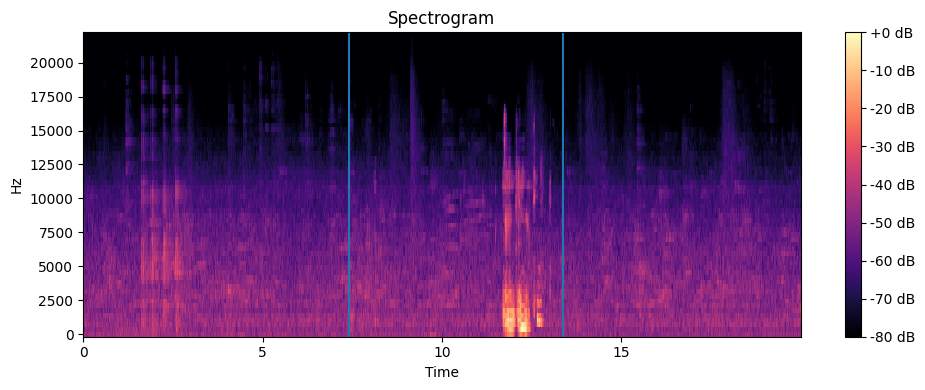

In [169]:
display_spectrogram(data['S_db'][val_idx[i]], data['sr'], val_onsets[i], val_offsets[i])

## Get test set event predictions

In [164]:
data_test = pickle.load(open('data/processed/yamnet/spectrograms_test.pkl', 'rb'))
filepaths_test = [os.path.join(DETECTION_TEST_PATH, file) for file in data_test['files']]

In [166]:
estimated_event_outputs = {}
for i in tqdm(range(len(filepaths_test))):
    test_path = filepaths_test[i]
    estimated_event = trainer.predict_events(test_path, audio_length=20)
    estimated_event_outputs[os.path.basename(test_path)] = estimated_event

os.makedirs("outputs", exist_ok=True)
with open(f"outputs/single_stage_yamnet.pkl", "wb") as f:
    pickle.dump(estimated_event_outputs, f)

100%|██████████| 500/500 [01:21<00:00,  6.16it/s]
